# Imports

In [37]:
# General
import os
import re
import sys
import string
import pytreebank
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import umap
import umap.plot
import numpy as np
import emoji

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import pairwise_distances

# NLTK
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Gensim
from gensim.models import Word2Vec

# Other
from wordcloud import WordCloud
from collections import OrderedDict
from collections import Counter

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
plt.style.use('bmh')

[nltk_data] Downloading package stopwords to
[nltk_data]     /afs/inf.ed.ac.uk/user/s21/s2125219/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /afs/inf.ed.ac.uk/user/s21/s2125219/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Helper functions

In [38]:
# Compute UMAP embeddings
def do_umap(X, n_neighbors, min_dist, n_components):
    embedding = umap.UMAP(
        n_neighbors=n_neighbors, 
        min_dist=min_dist, 
        n_components=n_components,
        random_state=42
    ).fit_transform(X)
    return embedding

# Plot umap embeddings
def plot_umap_embeddings(embeddings, labels, size, alpha):
    plt.figure(figsize=(10,6))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], 
                s=size, c=labels, edgecolor='none', alpha=alpha, cmap='Spectral')
    plt.show()
    
# Generate wordclouds
def generate_wordclouds(cluster_ids, word_positions, X):
    for c_id in cluster_ids:
        tfidf = X[y_pred == c_id]
        tfidf_sum = np.asarray(np.sum(tfidf, axis=0)).reshape(-1)
        top_indices = tfidf_sum.argsort()[-100:]
        term_weights = {word_positions[idx]: tfidf_sum[idx] for idx in top_indices}
        wc = WordCloud(width=1200, height=800, background_color="white")
        wordcloud = wc.generate_from_frequencies(term_weights)
        fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        fig.suptitle(f'Cluster: {c_id}')
        plt.show()

# Find the optimal number of components to maintain from SVD,PCA
def select_n_components(var_ratio, goal_var: float) -> int:
    total_variance = 0.0
    n_components = 0

    for explained_variance in var_ratio:
        total_variance += explained_variance
        n_components += 1

        if total_variance >= goal_var:
            break
            
    return n_components

# Preprocessor class

-

In [39]:
stop_words = stopwords.words('english')

class Preprocessor():
    def __init__(self, text):
        self.text = text
        self.vocab = set()
        self.og_text = text
        self.ps = PorterStemmer()
        self.emoji_pat = '[\U0001F300-\U0001F64F\U0001F680-\U0001F6FF\u2600-\u26FF\u2700-\u27BF]'
        self.reg_pat = re.compile(r'({})|[^!a-zA-Z]'.format(self.emoji_pat)) # Remove punctuation except emojis, and '!'
       
    def lowercase(self):
        self.text = self.text.lower()
    
    def remove_punct(self):
        self.text = self.reg_pat.sub(lambda x: ' {} '.format(x.group(1)) if x.group(1) else ' ', self.text)
        self.text = re.sub(' +', ' ', self.text)
    
    def remove_stopwords(self, stop_words):
        tokens = self.text.split()
        self.text = [word.rstrip()
                     for word in tokens if word not in stop_words]
        self.text = ' '.join(self.text)
    
    def stem(self):
        self.text = self.text.split()
        self.text = [self.ps.stem(word) for word in self.text]
        self.text = ' '.join(self.text)
    
    def tokenize(self):
        self.text = self.text.split()
            
    def join_tokens(self):
        self.text = ' '.join(self.text)
    
    def return_text(self):
        return self.text
    
    def preprocess(self):
        self.lowercase()
        self.remove_punct()
        self.remove_stopwords(stop_words)
        self.stem()
        self.tokenize()
        self.join_tokens()
        return self.return_text()

# Load Data

- It looks like exclamation marks may be important to keep. They're often used to further illustrate something positive or negative.

- "Brilliant" vs. "Brilliant!", second option more positive perhaps?

In [40]:
DATA_PATH = os.path.abspath('stanfordSentimentTreebank/')

phrases = pd.read_csv(DATA_PATH + '/dictionary.txt', delimiter = "|", names=['phrase', 'phrase_id1'])
labels = pd.read_csv(DATA_PATH + '/sentiment_labels.txt', delimiter = '|')
labels.columns = ['phrase_id2', 'sentiment_val']

In [41]:
phrase_df = phrases.set_index('phrase_id1').join(labels.set_index('phrase_id2'), how='inner')\
    .rename_axis(index='phrase_id').reset_index()

In [42]:
def label_sentiment_id(row):
    if row['sentiment_val'] > 0 and row['sentiment_val'] <= 0.2:
        return 1 # Very negative
    if row['sentiment_val'] > 0.2 and row['sentiment_val'] <= 0.4:
        return 2 # negative
    if row['sentiment_val'] > 0.4 and row['sentiment_val'] <= 0.6:
        return 3 # Neutral
    if row['sentiment_val'] > 0.6 and row['sentiment_val'] <= 0.8:
        return 4 # positive
    if row['sentiment_val'] > 0.8 and row['sentiment_val'] <= 1:
        return 5 # Very positive

def label_sentiment_name(row):
    if row['label_id'] == 1:
        return 'Very negative'
    if row['label_id'] == 2:
        return 'Negative'
    if row['label_id'] == 3:
        return 'Neutral'
    if row['label_id'] == 4:
        return 'Positive'
    if row['label_id'] == 5:
        return 'Very positive'

phrase_df['label_id'] = phrase_df.apply(lambda row: label_sentiment_id(row), axis=1)
phrase_df['label'] = phrase_df.apply(lambda row: label_sentiment_name(row), axis=1)
phrase_df = phrase_df.dropna()
phrase_df.head()

,phrase_id,phrase,sentiment_val,label_id,label
0,0,!,0.50000,3.0,Neutral
1,22935,! ',0.52778,3.0,Neutral
2,18235,! '',0.50000,3.0,Neutral
3,179257,! Alas,0.44444,3.0,Neutral
4,22936,! Brilliant,0.86111,5.0,Very positive


In [43]:
# Apply preprocessing to phrases, create new column with cleaned text. 
phrases = phrase_df['phrase'].values.tolist()
phrases_cleaned = [Preprocessor(phrase).preprocess() for phrase in phrases]
phrase_df['phrase_clean'] = phrases_cleaned

In [44]:
phrase_df.head()

,phrase_id,phrase,sentiment_val,label_id,label,phrase_clean
0,0,!,0.50000,3.0,Neutral,!
1,22935,! ',0.52778,3.0,Neutral,!
2,18235,! '',0.50000,3.0,Neutral,!
3,179257,! Alas,0.44444,3.0,Neutral,! ala
4,22936,! Brilliant,0.86111,5.0,Very positive,! brilliant


In [45]:
# Optionally remove duplicates -> Think this is the best course of action, 
# maintaining duplicates doesn't really help to train the model for general language use. 
phrase_df = phrase_df.drop_duplicates(subset=['phrase_clean']) 

filter = phrase_df['phrase_clean'] != ""
phrase_df = phrase_df[filter]

phrase_df = shuffle(phrase_df)
phrase_df.head()

,phrase_id,phrase,sentiment_val,label_id,label,phrase_clean
2742,141325,'s fitting,0.47222,3.0,Neutral,fit
33799,66430,Invincible is not quite the career peak that T...,0.48611,3.0,Neutral,invinc quit career peak pianist roman polanski
19224,24672,"Anchored by a terrific performance by Abbass ,...",0.76389,4.0,Positive,anchor terrif perform abbass satin roug show i...
159847,206777,mythic structure may owe more to Disney 's str...,0.27778,2.0,Negative,mythic structur may owe disney strong sens for...
216759,59051,thoroughly entertaining,0.87500,5.0,Very positive,thoroughli entertain


# Train/test/dev split on phrases

In [118]:
train, test = train_test_split(phrase_df, test_size=0.2)
train, dev = train_test_split(phrase_df, test_size=0.25)

In [119]:
X_train, y_train = train['phrase_clean'], train['label_id']
X_test, y_test = test['phrase_clean'], test['label_id']
X_dev, y_dev = dev['phrase_clean'], dev['label_id']

In [120]:
train_phrases = X_train.tolist()
dev_phrases = X_dev.tolist()
test_phrases = X_test.tolist()

# Exploratory Data Analysis

## Sentiment class balance

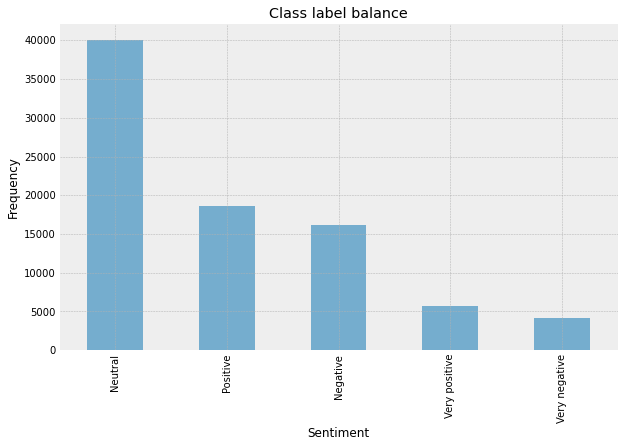

In [185]:
fig, ax = plt.subplots(figsize = (10,6))
ax = train['label'].sort_values(ascending=False).value_counts().plot(kind='bar', alpha=0.65)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Frequency')
ax.set_title('Class label balance')
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
        spine.set_visible(False)

plt.savefig('label_balance', dpi=300)

- Majority of the training instances are labelled neutral. 
- Positives and negatives are fairly balanced. 
- Since the majority are neutral, dataset is unbalanced.

### Text length

count    84768.00000
mean         4.69367
std          3.81718
min          1.00000
25%          2.00000
50%          3.00000
75%          6.00000
max         30.00000
Name: phrase_clean, dtype: float64


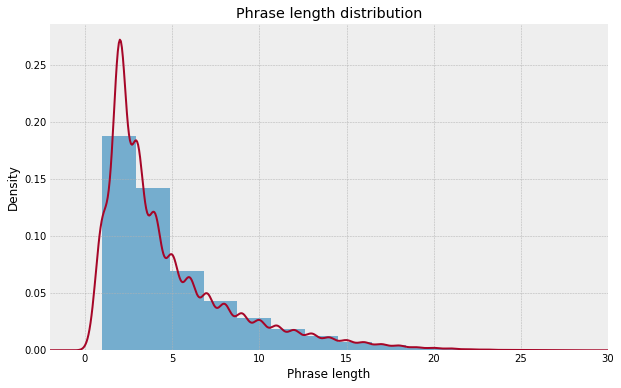

<Figure size 432x288 with 0 Axes>

In [186]:
def plot_text_length(text, title):
    lens = text.str.split().apply(lambda x:  len(x))
    print(lens.describe())
    
    fig, ax = plt.subplots(figsize = (10,6))
    lens.plot(kind='hist', density=True, bins=15, alpha=0.65)
    lens.plot(kind='kde')
    ax.set_xlabel("Phrase length")
    ax.set_ylabel("Density")
    ax.set_xlim(-2, 30)
    ax.set_title(title)
    ax.tick_params(left = False, bottom = False)

    for ax, spine in ax.spines.items():
        spine.set_visible(False)
    
    plt.show()

plot_text_length(train['phrase_clean'], title='Phrase length distribution')
plt.savefig('phrase len', dpi=300)

- Most of the phrases are consist of 1-10 words.
- Postively skewed (long right tail).
- Consequences: Model likely has an easier time classifying shorter phrases.

count    24356.000000
mean         5.579816
std          4.138348
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         29.000000
Name: phrase_clean, dtype: float64


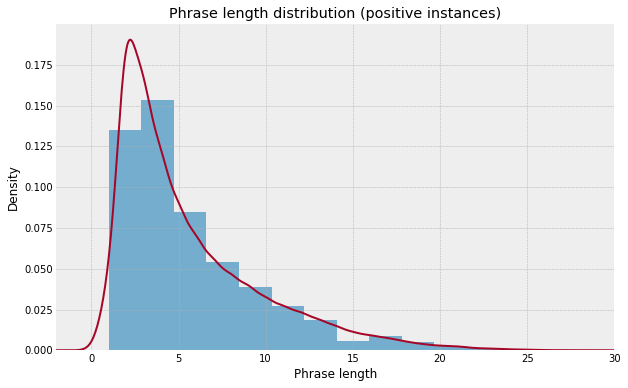

<Figure size 432x288 with 0 Axes>

In [187]:
# Positive sentences
plot_text_length(train[train['label_id'] > 3]['phrase_clean'], title='Phrase length distribution (positive instances)')
plt.savefig('phrase len pos', dpi=300)

- Positive instances also contain more short phrases.
- A few more cases of phrases with > 10 length.

count    20313.000000
mean         5.834835
std          4.209292
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         30.000000
Name: phrase_clean, dtype: float64


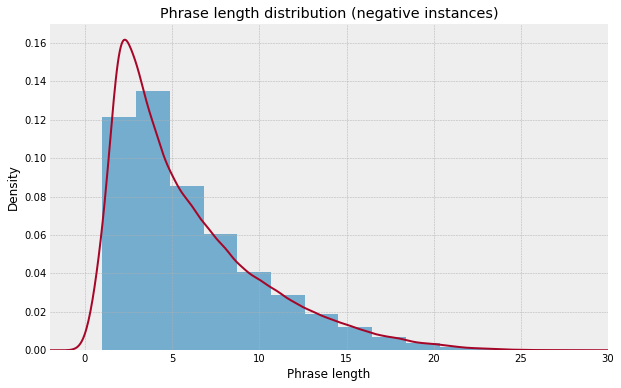

<Figure size 432x288 with 0 Axes>

In [188]:
# Negative sentences
plot_text_length(train[train['label_id'] < 3]['phrase_clean'], title='Phrase length distribution (negative instances)')
plt.savefig('Phrase len neg', dpi=300)

- Still heavily right skewed, however slightly less than the positive cases.
- Suggesting that phrases labelled negative are generally longer in the training data.

## Avg number of words per sentiment label

In [189]:
train['word_count'] = train['phrase_clean'].apply(lambda x: len(str(x).split()))

/afs/inf.ed.ac.uk/user/s21/s2125219/miniconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


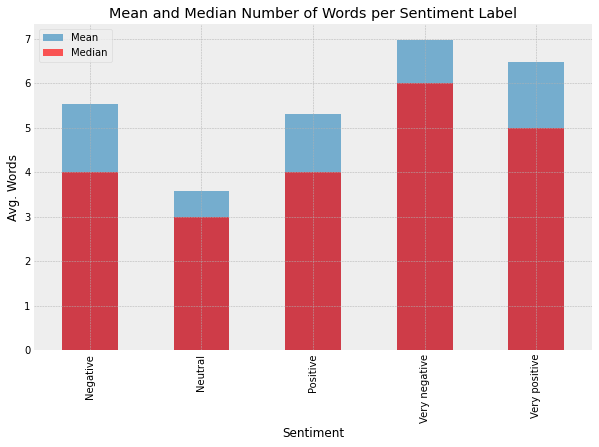

In [190]:
word_avg = train.groupby('label')['word_count']

fig, ax = plt.subplots(figsize = (10,6))
ax = word_avg.mean().plot(kind='bar', alpha=0.65)
ax = word_avg.median().plot(kind='bar', alpha=0.65, color='red')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Avg. Words')
ax.set_title('Mean and Median Number of Words per Sentiment Label')
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
        spine.set_visible(False)
plt.legend(['Mean', 'Median'])
plt.savefig('mean_med', dpi=300)

In [191]:
word_avg.mean()

label
Negative         5.538319
Neutral          3.577346
Positive         5.302956
Very negative    6.982023
Very positive    6.483284
Name: word_count, dtype: float64

In [192]:
word_avg.median()

label
Negative         4
Neutral          3
Positive         4
Very negative    6
Very positive    5
Name: word_count, dtype: int64

- Neutral phrases are short.
- Very postive and negative phrases contain on average a lot more words. 

# Dimensionality reduction

- No clear separation between phrases
- Will be difficult to categorize
- Text data is noisy. Perhaps reducing the number of labels -> Negative, Neutral, Positive?

## Tfidf Vectorizer

In [139]:
vectorizer = TfidfVectorizer(analyzer='word', 
                             max_features=500,
                             use_idf=True, 
                             ngram_range=(1,1))

In [140]:
X_tfidf = vectorizer.fit_transform(X_train)

### Truncated SVD

In [141]:
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

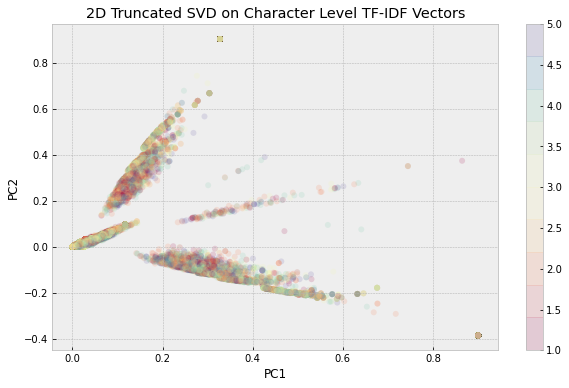

In [142]:
fig, ax = plt.subplots(figsize = (10,6))

plt.scatter(X_svd[:, 0], X_svd[:, 1], 
            c=y_train, 
            edgecolor='none', 
            alpha=0.15, 
            cmap=plt.cm.get_cmap('Spectral', 10))

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D Truncated SVD on Character Level TF-IDF Vectors')
plt.colorbar()

In [ ]:
tsvd = TruncatedSVD(n_components=X_tfidf.shape[1]-1)
X_svd = tsvd.fit(X_tfidf)
tsvd_var_ratios = tsvd.explained_variance_ratio_

In [ ]:
# Plot the explained variance vs. the number of components

fig, ax = plt.subplots(figsize = (10,6))

plt.plot(np.cumsum(tsvd.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
plt.title('Truncated SVD Cumulative Explained Variance vs. Number of Components')

plt.savefig('tsvd-comps', dpi=300)

In [ ]:
print(f'Optimal number of components: {select_n_components(tsvd_var_ratios, 0.95)}')

# Supervised prediction

## Dummy classifier

In [122]:
def dummy_pipeline(train, labels, dummy_strategy, is_truncated=False):
    clf = DummyClassifier(strategy=dummy_strategy)
    if not is_truncated:
        pipeline = Pipeline([
            ('vect', TfidfVectorizer(ngram_range=(1,2), analyzer='char', sublinear_tf=True)),
            ('clf', clf)
        ])
    pipeline.fit(train, labels)
    return pipeline

In [123]:
dummy_pipe_mf = dummy_pipeline(X_train, y_train, 'most_frequent')
dev_preds_mf = dummy_pipe_mf.predict(X_dev)

In [124]:
dev_acc_mf = accuracy_score(y_dev, dev_preds_mf)
dev_f1_mf = f1_score(y_dev, dev_preds_mf, average='weighted')

print(f'{dev_acc_mf:.3f}')
print(f'{dev_f1_mf:.3f}')

0.496
0.328


In [125]:
pred_counts = {}

for pred in dev_preds_mf:
    if pred in pred_counts:
        pred_counts[pred] += 1
    else:
        pred_counts[pred] = 0

pred_counts

{3.0: 59198}

- Dummy classifier predicts everything as 3.
- Thus, accuracy is bad evaluation metric since the dataset is imbalanced and the majority of sentiment labels are neutrla. 
- Will predict the correct case the majority of the time. 

In [126]:
dummy_pipe_strat = dummy_pipeline(X_train, y_train, 'stratified')
dev_preds_strat = dummy_pipe_strat.predict(X_dev)

In [127]:
dev_acc_strat = accuracy_score(y_dev, dev_preds_strat)
dev_f1_strat = f1_score(y_dev, dev_preds_strat, average='weighted')

print(f'{dev_acc_strat:.3f}')
print(f'{dev_f1_strat:.3f}')

0.330
0.330


In [128]:
pred_counts = {}

for pred in dev_preds_strat:
    if pred in pred_counts:
        pred_counts[pred] += 1
    else:
        pred_counts[pred] = 0

pred_counts

{2.0: 10727, 4.0: 12561, 3.0: 29286, 5.0: 3822, 1.0: 2798}

- Stratified DummyClassifier does a better job as it doesnt simply just predict neutral, i.e. the most frequent one.

# Unsupervised Clustering

- KMeans does not work well on high-dimensional data, better to reduce dimensionality of data first, and then do KMeans on reduced space: https://stats.stackexchange.com/questions/199501/user-segmentation-by-clustering-with-sparse-data

In [46]:
from sklearn import metrics

In [62]:
phrases, labels = phrase_df['phrase_clean'], phrase_df['label_id']

In [63]:
k_labels = phrase_df['label_id'].values.tolist()
true_k = np.unique(k_labels).shape[0]

In [109]:
vectorizer = TfidfVectorizer(analyzer='word', 
                             max_features=100,
                             use_idf=True, 
                             ngram_range=(1,1))

X = vectorizer.fit_transform(phrase_df['phrase_clean'])

In [110]:
# svd = TruncatedSVD(n_components=500)
# normalizer = Normalizer(copy=False)
# lsa = make_pipeline(svd, normalizer)
# X = lsa.fit_transform(X_vect)

# print(svd.explained_variance_ratio_.sum())

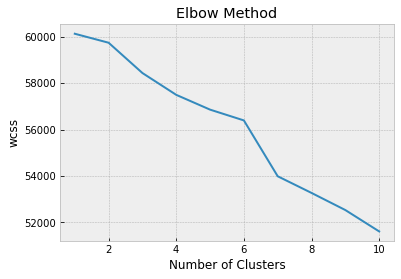

In [111]:
# Elbow method for finding optimal number of clusters
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=1, max_iter=100, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()

In [114]:
km = KMeans(n_clusters=6, init='k-means++', max_iter=100, n_init=1)
km.fit(X)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

Homogeneity: 0.006
Completeness: 0.016
V-measure: 0.009
Adjusted Rand-Index: 0.354
Silhouette Coefficient: 0.326


/afs/inf.ed.ac.uk/user/s21/s2125219/miniconda3/envs/dme/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
/afs/inf.ed.ac.uk/user/s21/s2125219/miniconda3/envs/dme/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))


In [115]:
# original_space_centroids = svd.inverse_transform(km.cluster_centers_)
# order_centroids = original_space_centroids.argsort()[:, ::-1]

order_centroids = km.cluster_centers_.argsort()[:, ::-1]

terms = vectorizer.get_feature_names()

for i in range(6):
    print("Cluster %d: " % i, end='')
    for idx in order_centroids[i, :200]:
        print(' %s' % terms[idx], end='')
    print('\n')

Cluster 0:  movi one charact stori make comedi perform even good work much director life littl well way funni get enough look us new plot come action audienc act entertain bad emot interest thing year two take feel end see self watch old best drama go never humor someth world would peopl live seem cast heart mani scene direct minut made everi give filmmak sens pictur star actor screen big long man could american may without play fun better hollywood still show origin anoth famili less great realli power first real noth enjoy ever tri kind find film like time love human

Cluster 1:  time movi good first film one long minut like mani much take well feel stori get director watch work make way everi seem screen come look big interest even real two great us give go charact could act old realli better plot littl direct live enjoy anoth funni emot life see end peopl still kind drama year someth sens audienc power action show less bad would cast tri actor filmmak play entertain find new thing 